#**Detecting Signs of Depression from Social Media Text**

##19MIA1085 -- Varun Ragul R
  
##19MIA1042 -- Adithya G

In [67]:
import numpy as np 
import pandas as pd

In [68]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [69]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy
nlp = spacy.load("en_core_web_lg")
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline

In [70]:
import warnings
warnings.filterwarnings("ignore")

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
data=pd.read_csv("/content/drive/MyDrive/Depression_Detection.csv")
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [73]:
data['class']=data['class'].str.replace('non-suicide','not depressed')
data['class']=data['class'].str.replace('suicide','severely depressed')

In [74]:
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,severely depressed
1,3,Am I weird I don't get affected by compliments...,not depressed
2,4,Finally 2020 is almost over... So I can never ...,not depressed
3,8,i need helpjust help me im crying so hard,severely depressed
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",severely depressed


In [75]:
data.shape

(232074, 3)

In [76]:
data_split=np.array_split(data,20)
df=data_split[0].copy()
df2=data_split[1].copy()
df3=data_split[2]
df4=data_split[3]
df5=data_split[4]
df6=data_split[5]

In [77]:
df=df.rename(columns={"class":"target"})

In [78]:
df.head()

,Unnamed: 0,text,target
0,2,Ex Wife Threatening SuicideRecently I left my ...,severely depressed
1,3,Am I weird I don't get affected by compliments...,not depressed
2,4,Finally 2020 is almost over... So I can never ...,not depressed
3,8,i need helpjust help me im crying so hard,severely depressed
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",severely depressed


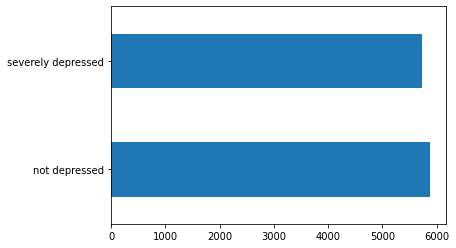

In [79]:
df.target.value_counts().plot.barh()

In [80]:
class TextPreprocessor(TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
        
    def transform(self,X, *_):
        X_copy=X.copy()
        X_copy[self.text_attribute]=X_copy[self.text_attribute].apply(self._preprocess_text)
        return X_copy
    
    def _preprocess_text(self,text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self,text):
        bad_symbols='!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols=text.translate(str.maketrans('','',bad_symbols))

        text_without_bad_words=''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words +=line + '\n'

        clean_text=text_without_bad_words
        email_regex=r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove=[email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text=re.sub(r,'', clean_text)
        return clean_text
    
    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self,text):
        doc=nlp(text)
        words=[x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' 
                                    and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)
    
    def fit(self, *_):
        return self

In [81]:
text_preprocessor=TextPreprocessor(text_attribute='text')
df_preprocessed=text_preprocessor.transform(df)

In [82]:
train,test=train_test_split(df_preprocessed,test_size=0.3)

In [83]:
tfidf_vectorizer=TfidfVectorizer(analyzer="word",max_features=10000)
X_tfidf_train=tfidf_vectorizer.fit_transform(train['text'])
X_tfidf_test=tfidf_vectorizer.transform(test['text'])

In [84]:
y=train['target']
y_test=test['target']

In [85]:
X,y=X_tfidf_train,y
X_test,y_test=X_tfidf_test,y_test

##Feature Scaling

In [86]:
scaler=MinMaxScaler()
X_norm=scaler.fit_transform(X.toarray())
X_test_norm=scaler.transform(X_test.toarray())

## Feature Selection

In [87]:
lsvc=LinearSVC(C=100,penalty='l1',max_iter=500,dual=False)
lsvc.fit(X_norm,y)
fs=SelectFromModel(lsvc,prefit=True)
X_sel=fs.transform(X_norm)
X_test_sel=fs.transform(X_test_norm)

In [88]:
from IPython.display import Markdown, display
def show_top10_features(classifier, feature_names, categories):
    for i,category in enumerate(categories):
        top10=np.argsort(classifier.coef_[0, i])[-100:]

In [89]:
feature_names=np.array(tfidf_vectorizer.get_feature_names())
show_top10_features(lsvc,feature_names, lsvc.classes_)

In [90]:
print("New dataset shape: ",X_sel.shape)
print("Reduced Number of Features: ",X_norm.shape[1]-X_sel.shape[1])

New dataset shape:  (8122, 2903)
Reduced Number of Features:  7097


## Predictive Models

In [91]:
def print_confusion_matrix(confusion_matrix, 
                           class_names, 
                           figsize=(8,8), 
                           fontsize=12,
                           ylabel='True label',
                           xlabel='Predicted label'):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=fontsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [92]:
def evaluate_model(model, X, y, X_test, y_test, target_names=None):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    print("Accuracy test: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std()))
    
    print("Test classification report: ")
    if target_names is None:
        target_names = model.classes_
    print(classification_report(y_test, model.predict(X_test), target_names=target_names))
    print("Test confusion matrix: ")
    print_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)), class_names=target_names)

## Multinomial Naive Bayes

Accuracy: 0.91 (+/- 0.00)
Accuracy test: 0.85 (+/- 0.02)
Test classification report: 
                    precision    recall  f1-score   support

     not depressed       0.94      0.80      0.87      1774
severely depressed       0.82      0.95      0.88      1708

          accuracy                           0.87      3482
         macro avg       0.88      0.87      0.87      3482
      weighted avg       0.88      0.87      0.87      3482

Test confusion matrix: 


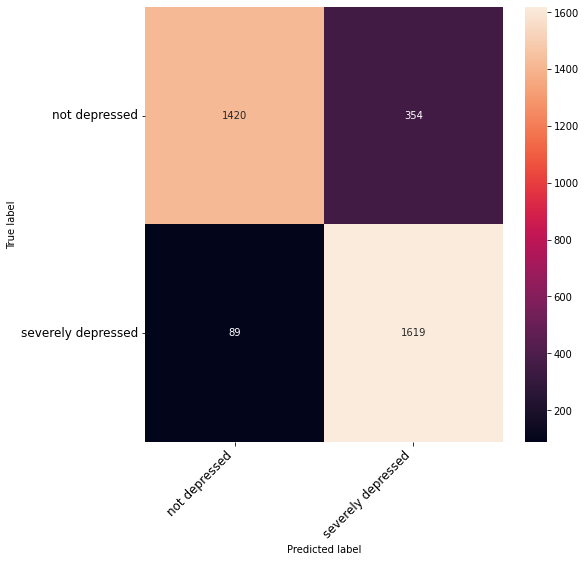

In [93]:
mb=MultinomialNB()
mb.fit(X_sel, y)
evaluate_model(mb,X_sel,y,X_test_sel,y_test)

## Logistic Regression

Accuracy: 0.92 (+/- 0.00)
Accuracy test: 0.88 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

     not depressed       0.90      0.90      0.90      1774
severely depressed       0.89      0.90      0.90      1708

          accuracy                           0.90      3482
         macro avg       0.90      0.90      0.90      3482
      weighted avg       0.90      0.90      0.90      3482

Test confusion matrix: 


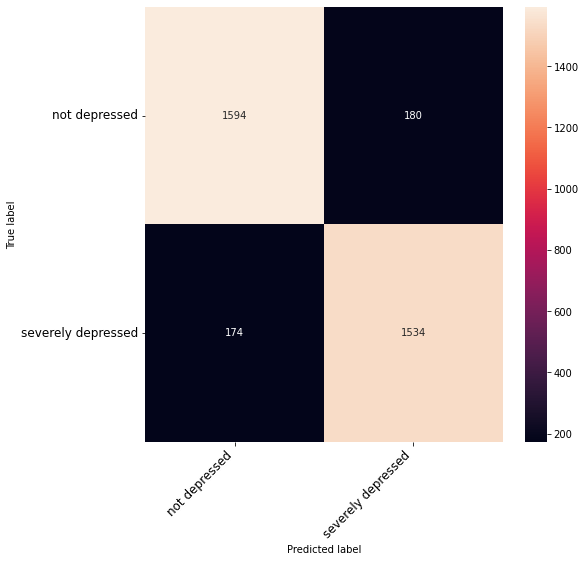

In [94]:
lr=LogisticRegression(multi_class='ovr',solver='liblinear',C=10,penalty='l2')
lr.fit(X_sel,y)
evaluate_model(lr,X_sel,y,X_test_sel,y_test)

## SGDClassifier

Accuracy: 0.91 (+/- 0.00)
Accuracy test: 0.88 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

     not depressed       0.91      0.91      0.91      1774
severely depressed       0.91      0.90      0.91      1708

          accuracy                           0.91      3482
         macro avg       0.91      0.91      0.91      3482
      weighted avg       0.91      0.91      0.91      3482

Test confusion matrix: 


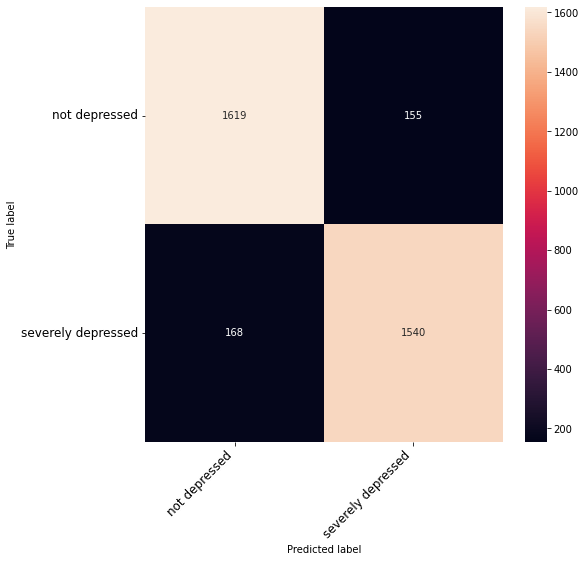

In [95]:
sgd=SGDClassifier(alpha=.0001, max_iter=50, loss='log',penalty="elasticnet", n_jobs=-1)
sgd.fit(X_sel,y)
evaluate_model(sgd, X_sel, y, X_test_sel, y_test)

## Soft Voting

Accuracy: 0.93 (+/- 0.00)
Accuracy test: 0.89 (+/- 0.01)
Test classification report: 
                    precision    recall  f1-score   support

     not depressed       0.91      0.90      0.90      1774
severely depressed       0.89      0.91      0.90      1708

          accuracy                           0.90      3482
         macro avg       0.90      0.90      0.90      3482
      weighted avg       0.90      0.90      0.90      3482

Test confusion matrix: 


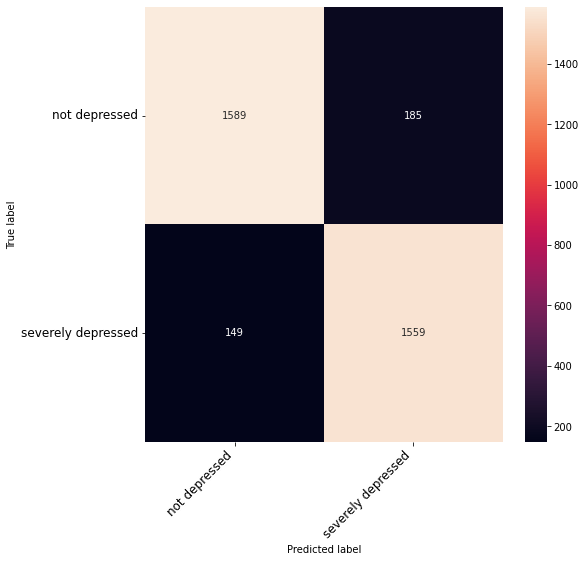

In [96]:
vclf_sgd=VotingClassifier(estimators=[
        ('lr',LogisticRegression(multi_class='ovr',solver='liblinear',C=10,penalty='l2')),
        ('mb',MultinomialNB()),
        ('sgd',SGDClassifier(alpha=.0001,max_iter=50,loss='log',penalty="elasticnet"))],voting='soft',n_jobs=-1)
vclf_sgd.fit(X_sel,y)
evaluate_model(vclf_sgd,X_sel,y,X_test_sel,y_test)

#Creating Pipeline

In [97]:
class TextPreprocessor(BaseEstimator,TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute
    
    def fit(self,X,y=None):
        return self
        
    def transform(self,X, *_):
        X_copy = X.copy()
        return X_copy[self.text_attribute].apply(self._preprocess_text)
    
    def _preprocess_text(self, text):
        return self._lemmatize(self._leave_letters_only(self._clean(text)))
    
    def _clean(self, text):
        bad_symbols='!"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words=''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text=text_without_bad_words
        email_regex=r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove=[email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_tex=re.sub(r,'',clean_text)
        return clean_text
    
    def _leave_letters_only(self,text):
        text_without_punctuation=text.translate(str.maketrans('','',string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))
    
    def _lemmatize(self, text):
        doc=nlp(text)
        words=[x.lemma_ for x in [y for y in doc if not y.is_stop and y.pos_ != 'PUNCT' and y.pos_ != 'PART' and y.pos_ != 'X']]
        return ' '.join(words)

In [98]:
class DenseTransformer(TransformerMixin):
    def fit(self,X,y=None, **fit_params):
        return self

    def transform(self,X,y=None, **fit_params):
        return X.todense()

In [99]:
text_classification_pipeline=Pipeline([
    ('text_preprocessor',TextPreprocessor(text_attribute='text')),
    ('vectorizer',TfidfVectorizer(analyzer = "word", max_features=10000)),
    ('todense_converter',DenseTransformer()),
    ('scaler',MinMaxScaler()),
    ('classifier',VotingClassifier(estimators=[
                        ('lr',LogisticRegression(multi_class='ovr', solver = 'liblinear', C=10, penalty = 'l2')),
                        ('mb',MultinomialNB()),
                        ('sgd',SGDClassifier(alpha=.0001, max_iter=50, loss='log', penalty="elasticnet"))], voting='soft', n_jobs=-1))])

# Testing Cases

In [133]:
X_p=df2.drop(columns=["class","Unnamed: 0"])
y_p=df2['class']
X_p.head()

,text
11604,I haven't done or been in remote classes and I...
11605,Let's mess up the billionaires And since we le...
11606,Why do people think every mistake can be fixed...
11607,"Sweden, a tool to further your political agend..."
11608,"My Mother is suicidal and has a plan, not sure..."


In [134]:
pipeline=text_classification_pipeline
pipeline.fit(X_p,y_p)

Pipeline(steps=[('text_preprocessor', TextPreprocessor(text_attribute='text')),
                ('vectorizer', TfidfVectorizer(max_features=10000)),
                ('todense_converter',
                 <__main__.DenseTransformer object at 0x7f74f08a7650>),
                ('scaler', MinMaxScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(C=10,
                                                                  multi_class='ovr',
                                                                  solver='liblinear')),
                                              ('mb', MultinomialNB()),
                                              ('sgd',
                                               SGDClassifier(loss='log',
                                                             max_iter=50,
                                                             penalty='elasticnet'))],
          

In [135]:
y_pred=pipeline.predict(X_p)

In [136]:
data=['Be happy with the little you have. There are some people with nothing who still manage to smile.Happiness can be found, even in the darkest of times, if one only remembers to turn on the light.Happiness is like knowledge; it increases, when you provide other persons, so try to make people happy.']
X_p_test=pd.DataFrame(data,columns=['text'])
X_p_test

,text
0,Be happy with the little you have. There are s...


In [ ]:
y_test_pred=pipeline.predict(X_p_test)
print("PREDICTION:",y_test_pred)

In [138]:
data=['The world is filled with pain, but only a few can agree to this because not too many truly live in this world. The rest live in their imagination.We all express our pain in different ways. I chose to write mine down and allow you to read them. I feel so much pain, and I cant explain the regret I feel.']
X_p_test1=pd.DataFrame(data,columns=['text'])
X_p_test1

,text
0,"The world is filled with pain, but only a few ..."


In [141]:
y_test_pred1=pipeline.predict(X_p_test)
print("PREDICTION:",y_test_pred1)

PREDICTION: ['not depressed']
